🎵 EXPERIMENT 2: FEATURE IMPORTANCE ANALYSIS (Memory Efficient)
🎯 Goal: Understand how multi-modal node features enhance recommendation accuracy
📊 Method: Test 5 different feature combinations across 1 random seed
📈 Focus: Feature value analysis, overfitting detection, performance comparison
🔧 Note: Using memory-efficient implementation with dataset sampling
⚡ Settings: Max 10K nodes, 2 layers, 10 epochs for faster execution
📁 Results will be saved to: ../results/experiment2

🔧 Using device: cpu
📁 Results will be saved to: ../results/experiment2
🧪 STARTING EXPERIMENT 2: FEATURE IMPORTANCE ANALYSIS

🔬 Testing Feature Config: NO_FEATURES
----------------------------------------
   🎲 Random seed: 42
📂 Loading data from ../data/processed/gnn_ready
⚠️  Warning: Could not load split_ratios: No module named 'numpy._core'
✅ Loaded data for 661,325 nodes
📊 Available split keys: ['train_edges', 'val_edges', 'test_edges', 'train_indices', 'val_indices', 'test_indices', 'negative_val', 'negative_te

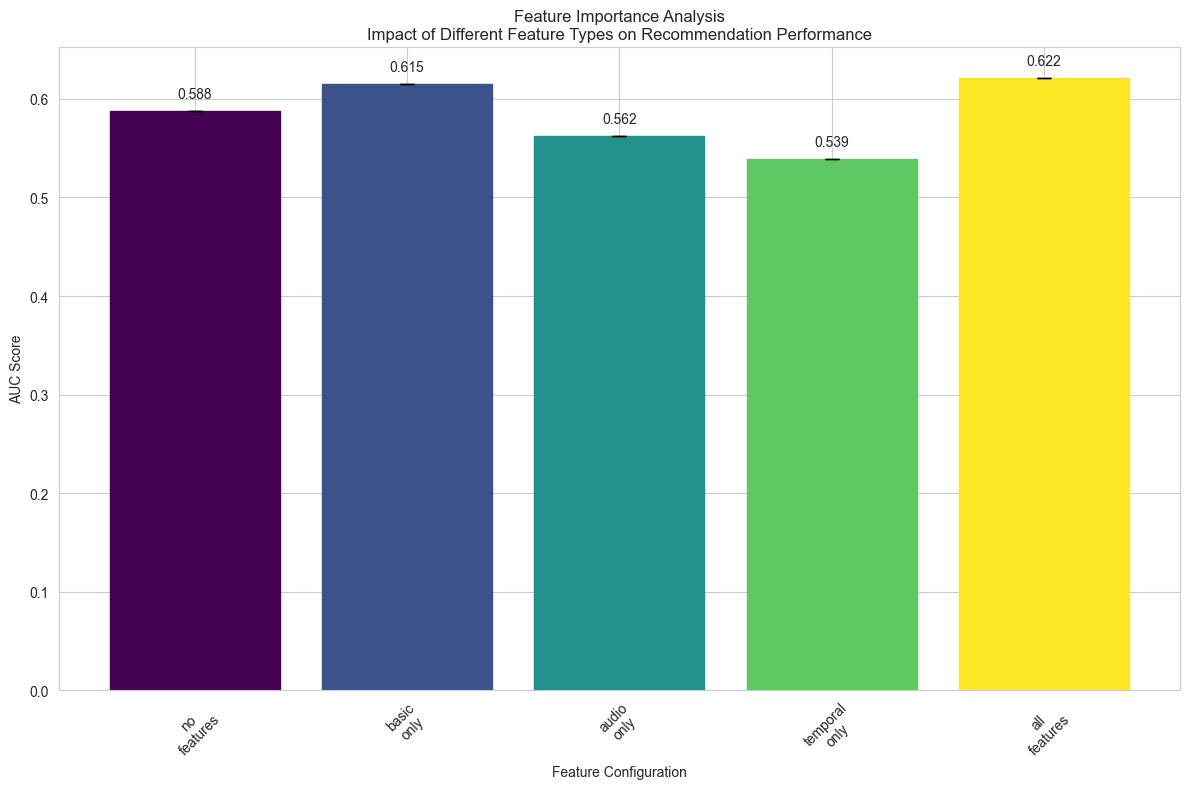

📈 Saved feature importance plot to: ../results/experiment2/plots/feature_importance_results.png


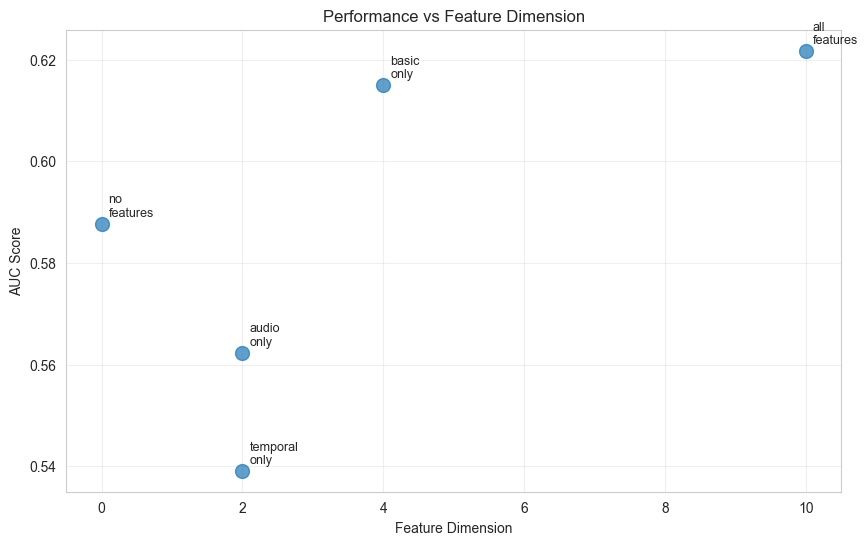

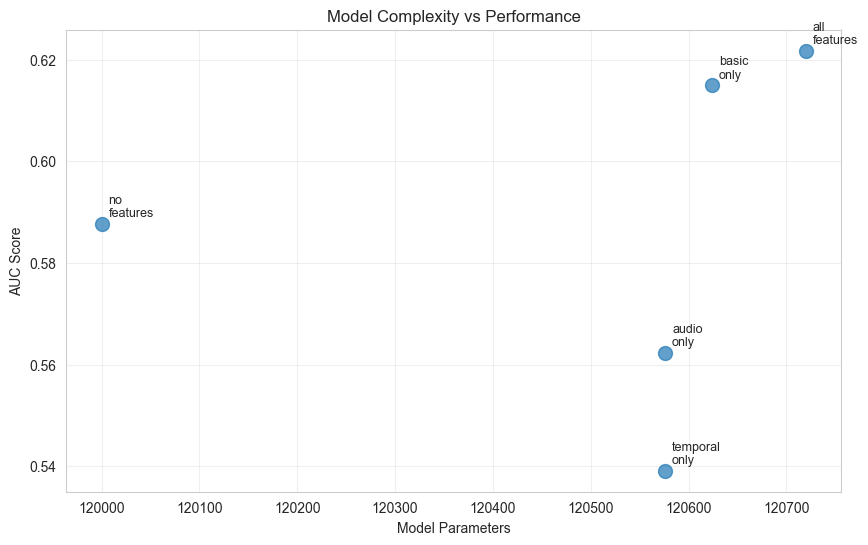

📊 Saved additional plots to: ../results/experiment2/plots/
💾 Saved detailed results to: ../results/experiment2/feature_importance_results.json
📊 Saved results table to: ../results/experiment2/results_table.csv
📝 Saved experiment summary to: ../results/experiment2/experiment_summary.txt

✅ EXPERIMENT 2 COMPLETED!
📁 All results saved to: ../results/experiment2
🔍 Check the following files:
   📊 Results: ../results/experiment2/feature_importance_results.json
   📈 Plots: ../results/experiment2/plots/
   🤖 Models: ../results/experiment2/models/
   📝 Summary: ../results/experiment2/experiment_summary.txt
   📋 Log: ../results/experiment2/experiment_log.json

📊 Key insights:
   • Which feature types are most valuable?
   • Do more features always improve performance?
   • Is there evidence of overfitting with complex features?


In [3]:
#!/usr/bin/env python3
"""
🧪 EXPERIMENT 2: Feature Importance Analysis (Memory Efficient) - FIXED VERSION
=============================================================================

This version fixes the device attribution error and ensures proper saving.
"""

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

class FeatureSelector:
    """Select different feature combinations for ablation study"""

    def __init__(self, features: Dict[str, np.ndarray]):
        self.all_features = features
        self.feature_configs = {
            'no_features': {
                'description': 'Pure graph structure (embeddings only)',
                'use_features': False,
                'feature_types': []
            },
            'basic_only': {
                'description': 'Simple metadata (playlist length, track popularity)',
                'use_features': True,
                'feature_types': ['basic_metadata']
            },
            'audio_only': {
                'description': 'Music features (danceability, energy, valence)',
                'use_features': True,
                'feature_types': ['audio_features']
            },
            'temporal_only': {
                'description': 'Time-based features (modification dates, collaborative status)',
                'use_features': True,
                'feature_types': ['temporal_features']
            },
            'all_features': {
                'description': 'Everything combined',
                'use_features': True,
                'feature_types': ['basic_metadata', 'audio_features', 'temporal_features']
            }
        }

    def get_feature_subset(self, config_name: str) -> Optional[Dict[str, np.ndarray]]:
        """Get feature subset for specific configuration"""
        config = self.feature_configs[config_name]

        if not config['use_features']:
            print(f"   🚫 {config_name}: No features used")
            return None

        selected_features = {}
        total_feature_dim = 0

        for node_type in ['playlists', 'tracks', 'artists', 'albums', 'users']:
            if node_type in self.all_features:
                features = self.all_features[node_type]
                print(f"   📊 {node_type}: Available features shape = {features.shape}")

                if config_name == 'basic_only':
                    # Use first 2 features (basic metadata)
                    selected = features[:, :min(2, features.shape[1])]
                    selected_features[node_type] = selected
                    total_feature_dim += selected.shape[1]
                    print(f"   ✅ {config_name} - {node_type}: Using {selected.shape[1]} basic features")

                elif config_name == 'audio_only' and node_type == 'tracks':
                    # Use middle features (audio features for tracks)
                    if features.shape[1] >= 4:
                        mid_idx = features.shape[1] // 2
                        end_idx = min(mid_idx + 2, features.shape[1])
                        selected = features[:, mid_idx:end_idx]
                        selected_features[node_type] = selected
                        total_feature_dim += selected.shape[1]
                        print(f"   ✅ {config_name} - {node_type}: Using {selected.shape[1]} audio features")

                elif config_name == 'temporal_only' and node_type in ['playlists', 'users']:
                    # Use last features (temporal features)
                    if features.shape[1] >= 2:
                        selected = features[:, -2:]
                        selected_features[node_type] = selected
                        total_feature_dim += selected.shape[1]
                        print(f"   ✅ {config_name} - {node_type}: Using {selected.shape[1]} temporal features")

                elif config_name == 'all_features':
                    # Use all features
                    selected_features[node_type] = features
                    total_feature_dim += features.shape[1]
                    print(f"   ✅ {config_name} - {node_type}: Using {features.shape[1]} all features")

        print(f"   📈 Total feature dimensions for {config_name}: {total_feature_dim}")
        return selected_features if selected_features else None

class MemoryEfficientLightGCN(nn.Module):
    """Memory-efficient LightGCN using sparse operations and edge lists"""

    def __init__(self, num_nodes: int, embedding_dim: int = 64, num_layers: int = 2,
                 node_features: Optional[Dict[str, torch.Tensor]] = None,
                 node_mappings: Optional[Dict] = None):
        super().__init__()

        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.node_features = node_features
        self.node_mappings = node_mappings

        # Node embeddings (always present)
        self.node_embedding = nn.Embedding(num_nodes, embedding_dim)

        # Feature projection layers (if features are used)
        if node_features is not None:
            self.use_features = True
            self.feature_projections = nn.ModuleDict()

            for node_type, features in node_features.items():
                if features is not None and features.shape[1] > 0:
                    feat_dim = features.shape[1]
                    self.feature_projections[node_type] = nn.Linear(feat_dim, embedding_dim)

            # Combine embeddings and features
            self.combine_layer = nn.Linear(embedding_dim * 2, embedding_dim)
        else:
            self.use_features = False

        # Initialize embeddings
        nn.init.normal_(self.node_embedding.weight, std=0.1)

    def sparse_graph_convolution(self, embeddings: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """Efficient graph convolution using edge list"""
        row, col = edge_index[0], edge_index[1]

        # Simple aggregation: sum of neighbor embeddings
        out = torch.zeros_like(embeddings)
        out.index_add_(0, row, embeddings[col])

        # Normalize by degree (simplified)
        degree = torch.bincount(row, minlength=self.num_nodes).float().clamp(min=1)
        out = out / degree.view(-1, 1)

        return out

    def get_initial_embeddings(self) -> torch.Tensor:
        """Get initial node embeddings (structure + features)"""
        # Start with learnable embeddings
        embeddings = self.node_embedding.weight

        # Add features if available
        if self.use_features and self.node_features is not None:
            print(f"      🔧 Incorporating features into embeddings...")
            feature_embeddings = torch.zeros_like(embeddings)

            for node_type, features in self.node_features.items():
                if features is not None and node_type in self.feature_projections:
                    print(f"         Processing {node_type} features: {features.shape}")

                    # Project features
                    projected = self.feature_projections[node_type](features)
                    print(f"         Projected to: {projected.shape}")

                    # Add to appropriate node positions
                    if node_type == 'playlists':
                        # Playlists are at indices 0 to num_playlists-1
                        num_playlists = len(projected)
                        feature_embeddings[:num_playlists] = projected
                        print(f"         Added playlist features to indices 0:{num_playlists}")
                    elif node_type == 'tracks':
                        # Tracks are at indices num_playlists to num_playlists+num_tracks-1
                        num_playlists = feature_embeddings.shape[0] - len(projected)
                        feature_embeddings[num_playlists:] = projected
                        print(f"         Added track features to indices {num_playlists}:{feature_embeddings.shape[0]}")

            # Combine structural and feature embeddings
            combined_input = torch.cat([embeddings, feature_embeddings], dim=1)
            embeddings = self.combine_layer(combined_input)
            print(f"      ✅ Combined embeddings shape: {embeddings.shape}")
        else:
            print(f"      📊 Using only structural embeddings: {embeddings.shape}")

        return embeddings

    def forward(self, edge_index: torch.Tensor) -> torch.Tensor:
        """Forward pass through the model"""
        # Get initial embeddings (structure + features)
        embeddings = self.get_initial_embeddings()

        # Store all layer embeddings
        all_embeddings = [embeddings]

        # Apply graph convolution layers
        current_embeddings = embeddings
        for layer in range(self.num_layers):
            current_embeddings = self.sparse_graph_convolution(current_embeddings, edge_index)
            all_embeddings.append(current_embeddings)

        # LightGCN: average all layer embeddings
        final_embeddings = torch.stack(all_embeddings, dim=0).mean(dim=0)

        return final_embeddings

class MusicRecommendationDataset:
    """Dataset class for music recommendation with feature selection"""

    def __init__(self, data_dir: str, feature_config: str = 'all_features', max_nodes: int = 10000):
        self.data_dir = data_dir
        self.feature_config = feature_config
        self.max_nodes = max_nodes

        # Load data
        self._load_data()

        # Sample dataset if too large
        if sum(self.entity_counts.values()) > max_nodes:
            print(f"🔪 Dataset too large ({sum(self.entity_counts.values()):,} nodes), sampling to {max_nodes:,} nodes")
            self._sample_dataset()

        # Initialize feature selector
        self.feature_selector = FeatureSelector(self.features)

        print(f"🔍 Available features after sampling:")
        for node_type, features in self.features.items():
            print(f"   {node_type}: {features.shape}")

        # Get feature subset for this experiment
        print(f"🎯 Selecting features for config: {feature_config}")
        self.selected_features = self.feature_selector.get_feature_subset(feature_config)

        if self.selected_features:
            print(f"✅ Selected features:")
            for node_type, features in self.selected_features.items():
                print(f"   {node_type}: {features.shape}")
        else:
            print(f"❌ No features selected for {feature_config}")

        print(f"✅ Dataset initialized with feature config: {feature_config}")

    def _load_data(self):
        """Load preprocessed data"""
        print(f"📂 Loading data from {self.data_dir}")

        try:
            # Load mappings
            with open(f"{self.data_dir}/mappings.pkl", 'rb') as f:
                self.mappings = pickle.load(f)

            # Load entity counts
            with open(f"{self.data_dir}/entity_counts.pkl", 'rb') as f:
                self.entity_counts = pickle.load(f)

            # Load edges (allow pickle for object arrays)
            edges_data = np.load(f"{self.data_dir}/edges.npz", allow_pickle=True)
            self.edges = {key: edges_data[key] for key in edges_data.files}

            # Load features (allow pickle for object arrays)
            features_data = np.load(f"{self.data_dir}/features.npz", allow_pickle=True)
            self.features = {key: features_data[key] for key in features_data.files}

            # Load splits (allow pickle for object arrays)
            splits_data = np.load(f"{self.data_dir}/splits.npz", allow_pickle=True)
            self.splits = {}

            # Load all splits data carefully
            for key in splits_data.files:
                try:
                    data = splits_data[key]
                    # Convert to regular numpy array if it's an object array
                    if hasattr(data, 'dtype') and data.dtype == object:
                        try:
                            data = np.array(data.tolist())
                        except:
                            print(f"⚠️  Warning: Could not convert {key} from object array")
                    self.splits[key] = data
                except Exception as e:
                    print(f"⚠️  Warning: Could not load {key}: {e}")

            print(f"✅ Loaded data for {sum(self.entity_counts.values()):,} nodes")
            print(f"📊 Available split keys: {list(self.splits.keys())}")
            print(f"🔍 Available feature keys: {list(self.features.keys())}")
            print(f"📋 Feature shapes:")
            for key, features in self.features.items():
                print(f"   {key}: {features.shape}")

        except Exception as e:
            print(f"❌ Error loading data: {e}")
            raise

    def _sample_dataset(self):
        """Sample dataset to manageable size with proper index remapping"""
        print(f"🎯 Sampling dataset to {self.max_nodes:,} nodes...")

        # Focus on playlist-track subgraph for recommendation task
        playlist_track_edges = self.edges.get('playlist_track', np.array([]))

        if len(playlist_track_edges) == 0:
            print("⚠️  No playlist-track edges found!")
            return

        # Sample playlists and tracks based on connectivity
        max_playlists = min(self.entity_counts.get('playlists', 0), self.max_nodes // 4)
        max_tracks = min(self.entity_counts.get('tracks', 0), self.max_nodes // 2)

        # Get most connected playlists and tracks
        playlist_counts = np.bincount(playlist_track_edges[:, 0], minlength=self.entity_counts['playlists'])
        track_counts = np.bincount(playlist_track_edges[:, 1], minlength=self.entity_counts['tracks'])

        # Select top connected nodes
        top_playlists = np.argsort(playlist_counts)[-max_playlists:]
        top_tracks = np.argsort(track_counts)[-max_tracks:]

        print(f"   Selected top {len(top_playlists)} playlists and {len(top_tracks)} tracks")

        # Create remapping dictionaries (old_id -> new_id)
        playlist_remap = {old_id: new_id for new_id, old_id in enumerate(top_playlists)}
        track_remap = {old_id: new_id + len(top_playlists) for new_id, old_id in enumerate(top_tracks)}

        # Filter and remap playlist-track edges
        mask = np.isin(playlist_track_edges[:, 0], top_playlists) & \
               np.isin(playlist_track_edges[:, 1], top_tracks)
        filtered_edges = playlist_track_edges[mask]

        # Remap edge indices
        remapped_edges = np.zeros_like(filtered_edges)
        remapped_edges[:, 0] = [playlist_remap[old_id] for old_id in filtered_edges[:, 0]]
        remapped_edges[:, 1] = [track_remap[old_id] for old_id in filtered_edges[:, 1]]

        self.edges['playlist_track'] = remapped_edges

        # Remove other edge types to simplify (focus on recommendation task)
        edges_to_keep = ['playlist_track']
        self.edges = {k: v for k, v in self.edges.items() if k in edges_to_keep}

        # Update entity counts
        self.entity_counts = {
            'playlists': len(top_playlists),
            'tracks': len(top_tracks),
            'artists': 0,
            'albums': 0,
            'users': 0
        }

        # Remap features with proper indexing
        print(f"   🔧 Remapping features...")

        # Map the actual feature keys to our expected keys
        new_features = {}

        for original_key, features in self.features.items():
            if original_key in ['playlist', 'playlists']:
                print(f"      Original playlist features ({original_key}): {features.shape}")
                new_features['playlists'] = features[top_playlists]
                print(f"      Remapped playlist features: {new_features['playlists'].shape}")

            elif original_key in ['track', 'tracks']:
                print(f"      Original track features ({original_key}): {features.shape}")
                new_features['tracks'] = features[top_tracks]
                print(f"      Remapped track features: {new_features['tracks'].shape}")
            else:
                print(f"      Skipping {original_key} features (not used in sampled graph)")

        # Update features dictionary
        self.features = new_features

        # Remap splits
        for split_key in ['train_edges', 'val_edges', 'test_edges']:
            if split_key in self.splits:
                edges = self.splits[split_key]
                # Only keep edges that are in our subset
                mask = np.isin(edges[:, 0], top_playlists) & \
                       np.isin(edges[:, 1], top_tracks)
                filtered_split_edges = edges[mask]

                if len(filtered_split_edges) > 0:
                    # Remap indices
                    remapped_split_edges = np.zeros_like(filtered_split_edges)
                    remapped_split_edges[:, 0] = [playlist_remap[old_id] for old_id in filtered_split_edges[:, 0]]
                    remapped_split_edges[:, 1] = [track_remap[old_id] for old_id in filtered_split_edges[:, 1]]
                    self.splits[split_key] = remapped_split_edges
                else:
                    # Create dummy splits if empty
                    self.splits[split_key] = np.array([[0, len(top_playlists)], [1, len(top_playlists)+1]])

        # Remap negative samples
        for neg_key in ['negative_val', 'negative_test']:
            if neg_key in self.splits:
                edges = self.splits[neg_key]
                mask = np.isin(edges[:, 0], top_playlists) & \
                       np.isin(edges[:, 1], top_tracks)
                filtered_neg_edges = edges[mask]

                if len(filtered_neg_edges) > 0:
                    remapped_neg_edges = np.zeros_like(filtered_neg_edges)
                    remapped_neg_edges[:, 0] = [playlist_remap[old_id] for old_id in filtered_neg_edges[:, 0]]
                    remapped_neg_edges[:, 1] = [track_remap[old_id] for old_id in filtered_neg_edges[:, 1]]
                    self.splits[neg_key] = remapped_neg_edges

        print(f"✅ Sampled and remapped to {sum(self.entity_counts.values()):,} nodes")
        print(f"   📊 Final: {self.entity_counts['playlists']} playlists, {self.entity_counts['tracks']} tracks")

class FeatureImportanceExperiment:
    """Main experiment class for feature importance analysis"""

    def __init__(self, data_dir: str, config: Dict, result_dir: str = "../result/experiment2"):
        self.data_dir = data_dir
        self.config = config
        self.result_dir = result_dir
        self.results = {}

        # Set device FIRST
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🔧 Using device: {self.device}")

        # Create result directory
        os.makedirs(result_dir, exist_ok=True)
        os.makedirs(f"{result_dir}/models", exist_ok=True)
        os.makedirs(f"{result_dir}/plots", exist_ok=True)
        os.makedirs(f"{result_dir}/logs", exist_ok=True)

        print(f"📁 Results will be saved to: {result_dir}")

        # Initialize experiment log
        self.experiment_log = []
        self._log_experiment_start()

    def _log_experiment_start(self):
        """Log experiment start details"""
        start_log = {
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'experiment': 'Feature Importance Analysis (Experiment 2)',
            'config': self.config,
            'device': str(self.device),
            'data_dir': self.data_dir,
            'result_dir': self.result_dir
        }
        self.experiment_log.append(start_log)

        # Save initial log
        with open(f"{self.result_dir}/experiment_log.json", 'w') as f:
            json.dump(self.experiment_log, f, indent=2)

    def _save_model(self, model: nn.Module, config_name: str, seed: int, metrics: Dict):
        """Save trained model and its metadata"""
        model_dir = f"{self.result_dir}/models/{config_name}"
        os.makedirs(model_dir, exist_ok=True)

        # Save model state dict
        model_path = f"{model_dir}/model_seed_{seed}.pth"
        torch.save(model.state_dict(), model_path)

        # Save model metadata
        metadata = {
            'config_name': config_name,
            'seed': seed,
            'model_params': sum(p.numel() for p in model.parameters()),
            'embedding_dim': self.config['embedding_dim'],
            'num_layers': self.config['num_layers'],
            'test_metrics': metrics,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }

        metadata_path = f"{model_dir}/metadata_seed_{seed}.json"
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)

        print(f"      💾 Saved model to: {model_path}")
        return model_path

    def run_experiment(self):
        """Run the complete feature importance experiment"""
        print("🧪 STARTING EXPERIMENT 2: FEATURE IMPORTANCE ANALYSIS")
        print("=" * 60)

        # Feature configurations to test
        feature_configs = ['no_features', 'basic_only', 'audio_only', 'temporal_only', 'all_features']

        for config_name in feature_configs:
            print(f"\n🔬 Testing Feature Config: {config_name.upper()}")
            print("-" * 40)

            # Run multiple seeds for this configuration
            config_results = []
            for seed in self.config['random_seeds']:
                print(f"   🎲 Random seed: {seed}")

                # Set seed
                torch.manual_seed(seed)
                np.random.seed(seed)

                # Run single experiment
                result = self._run_single_experiment(config_name, seed)
                config_results.append(result)

            # Aggregate results across seeds
            self.results[config_name] = self._aggregate_results(config_results)

        # Analyze and save results
        self._analyze_results()
        self._save_results()

    def _run_single_experiment(self, feature_config: str, seed: int) -> Dict:
        """Run single experiment with specific feature configuration"""
        # Load dataset with specific feature configuration (smaller sample for testing)
        dataset = MusicRecommendationDataset(self.data_dir, feature_config, max_nodes=10000)

        # Build edge index with ALL edge types
        edge_index = self._build_edge_index(dataset)

        # Prepare features for model
        node_features = None
        feature_dim = 0

        if dataset.selected_features is not None:
            print(f"      🔧 Preparing features for model...")
            # Convert features to tensors
            node_features = {}

            for node_type, features in dataset.selected_features.items():
                if features is not None and features.shape[1] > 0:
                    print(f"         {node_type}: {features.shape} -> tensor")
                    node_features[node_type] = torch.FloatTensor(features).to(self.device)
                    feature_dim += features.shape[1]

            print(f"      📊 Total feature dimension: {feature_dim}")

            if feature_dim == 0:
                print(f"      ⚠️  No valid features found, falling back to structure-only")
                node_features = None
        else:
            print(f"      📊 No features selected for {feature_config}")

        print(f"      🎯 Feature config: {feature_config}, Features: {node_features is not None}, Dim: {feature_dim}")

        # Create model
        num_nodes = sum(dataset.entity_counts.values())
        model = MemoryEfficientLightGCN(
            num_nodes=num_nodes,
            embedding_dim=self.config['embedding_dim'],
            num_layers=self.config['num_layers'],
            node_features=node_features,
            node_mappings=dataset.mappings
        ).to(self.device)

        print(f"      📊 Model: {num_nodes:,} nodes, {sum(p.numel() for p in model.parameters()):,} parameters")

        # Training setup
        optimizer = torch.optim.Adam(model.parameters(), lr=self.config['learning_rate'])

        # Convert edge index to tensor
        edge_index = edge_index.to(self.device)

        # Training loop
        model.train()
        train_losses = []
        val_scores = []

        for epoch in range(self.config['num_epochs']):
            start_time = time.time()

            # Forward pass
            embeddings = model(edge_index)

            # Compute loss (BPR loss for recommendation)
            loss = self._compute_bpr_loss(embeddings, dataset)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # Validation every 5 epochs
            if epoch % 5 == 0:
                val_score = self._evaluate_model(model, dataset, edge_index, 'val')
                val_scores.append((epoch, val_score))

                epoch_time = time.time() - start_time
                print(f"      Epoch {epoch:3d}: Loss={loss.item():.4f}, "
                      f"Val-AUC={val_score['auc']:.4f}, Time={epoch_time:.2f}s")

        # Final evaluation
        test_metrics = self._evaluate_model(model, dataset, edge_index, 'test')

        # Save the trained model
        model_path = self._save_model(model, feature_config, seed, test_metrics)

        # Log this run
        run_log = {
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'feature_config': feature_config,
            'seed': seed,
            'num_nodes': num_nodes,
            'feature_dim': feature_dim,
            'model_params': sum(p.numel() for p in model.parameters()),
            'final_train_loss': train_losses[-1] if train_losses else 0,
            'test_metrics': test_metrics,
            'model_path': model_path
        }
        self.experiment_log.append(run_log)

        # Update experiment log file
        with open(f"{self.result_dir}/experiment_log.json", 'w') as f:
            json.dump(self.experiment_log, f, indent=2)

        return {
            'feature_config': feature_config,
            'seed': seed,
            'train_losses': train_losses,
            'val_scores': val_scores,
            'test_metrics': test_metrics,
            'model_params': sum(p.numel() for p in model.parameters()),
            'feature_dim': feature_dim,
            'num_nodes': num_nodes,
            'model_path': model_path
        }

    def _build_edge_index(self, dataset: MusicRecommendationDataset) -> torch.Tensor:
        """Build edge index using ALL edge types (memory efficient)"""
        print(f"🔗 Building edge index...")

        all_edges = []
        edge_count = 0

        # Add all edge types from the dataset
        for edge_type, edges in dataset.edges.items():
            if len(edges) > 0:
                print(f"   Adding {len(edges):,} edges of type: {edge_type}")

                # Convert edges to numpy array, handling different data types
                try:
                    if isinstance(edges, np.ndarray):
                        edge_array = edges
                    else:
                        edge_array = np.array(edges)

                    # Ensure edges are within bounds
                    num_nodes = sum(dataset.entity_counts.values())
                    valid_mask = (edge_array[:, 0] < num_nodes) & (edge_array[:, 1] < num_nodes)
                    valid_edges = edge_array[valid_mask]

                    if len(valid_edges) < len(edge_array):
                        print(f"   ⚠️  Filtered {len(edge_array) - len(valid_edges)} out-of-bounds edges")

                    if len(valid_edges) > 0:
                        all_edges.append(valid_edges)
                        edge_count += len(valid_edges)

                except Exception as e:
                    print(f"   ⚠️  Error processing {edge_type} edges: {e}")

        # Combine all edges
        if all_edges:
            combined_edges = np.vstack(all_edges)
            # Add reverse edges for undirected graph
            reverse_edges = np.column_stack([combined_edges[:, 1], combined_edges[:, 0]])
            final_edges = np.vstack([combined_edges, reverse_edges])
            edge_index = torch.LongTensor(final_edges.T)
        else:
            edge_index = torch.LongTensor([[0], [1]])  # Dummy edge

        print(f"✅ Built edge index with {edge_count:,} total edges")
        return edge_index

    def _compute_bpr_loss(self, embeddings: torch.Tensor, dataset: MusicRecommendationDataset) -> torch.Tensor:
        """Compute BPR (Bayesian Personalized Ranking) loss"""
        # Get positive edges (playlist-track pairs from training set)
        try:
            train_edges = dataset.splits['train_edges']
            if isinstance(train_edges, np.ndarray) and hasattr(train_edges, 'dtype') and train_edges.dtype == object:
                train_edges = np.array(train_edges.tolist())
            pos_edges = torch.LongTensor(train_edges).to(self.device)
        except Exception as e:
            print(f"⚠️  Error loading train edges: {e}")
            # Fallback: create dummy edges
            pos_edges = torch.LongTensor([[0, 1], [1, 2]]).to(self.device)

        # Limit batch size for memory efficiency
        max_batch = min(500, len(pos_edges))
        if len(pos_edges) > max_batch:
            indices = torch.randperm(len(pos_edges))[:max_batch]
            pos_edges = pos_edges[indices]

        # Sample negative edges
        neg_edges = self._sample_negative_edges(pos_edges, dataset.entity_counts)

        # Get embeddings for positive and negative pairs
        playlist_pos = embeddings[pos_edges[:, 0]]
        track_pos = embeddings[pos_edges[:, 1]]

        playlist_neg = embeddings[neg_edges[:, 0]]
        track_neg = embeddings[neg_edges[:, 1]]

        # Compute scores
        pos_scores = (playlist_pos * track_pos).sum(dim=1)
        neg_scores = (playlist_neg * track_neg).sum(dim=1)

        # BPR loss
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()

        return loss

    def _sample_negative_edges(self, pos_edges: torch.Tensor,
                               entity_counts: Dict) -> torch.Tensor:
        """Sample negative edges for training"""
        num_samples = len(pos_edges)
        num_playlists = entity_counts['playlists']
        num_tracks = entity_counts['tracks']

        # Random negative sampling within valid ranges
        # Playlists are indices 0 to num_playlists-1
        # Tracks are indices num_playlists to num_playlists+num_tracks-1
        neg_playlists = torch.randint(0, num_playlists, (num_samples,), device=self.device)
        neg_tracks = torch.randint(num_playlists, num_playlists + num_tracks, (num_samples,), device=self.device)

        return torch.stack([neg_playlists, neg_tracks], dim=1)

    def _evaluate_model(self, model: nn.Module, dataset: MusicRecommendationDataset,
                        edge_index: torch.Tensor, split: str) -> Dict:
        """Evaluate model performance"""
        model.eval()

        with torch.no_grad():
            embeddings = model(edge_index)

            # Get test edges with error handling
            try:
                if split == 'val':
                    val_edges = dataset.splits.get('val_edges')
                    if val_edges is not None:
                        if isinstance(val_edges, np.ndarray) and hasattr(val_edges, 'dtype') and val_edges.dtype == object:
                            val_edges = np.array(val_edges.tolist())
                        pos_edges = torch.LongTensor(val_edges).to(self.device)
                    else:
                        test_edges = dataset.splits.get('test_edges')
                        if isinstance(test_edges, np.ndarray) and hasattr(test_edges, 'dtype') and test_edges.dtype == object:
                            test_edges = np.array(test_edges.tolist())
                        pos_edges = torch.LongTensor(test_edges).to(self.device)
                else:
                    test_edges = dataset.splits.get('test_edges')
                    if isinstance(test_edges, np.ndarray) and hasattr(test_edges, 'dtype') and test_edges.dtype == object:
                        test_edges = np.array(test_edges.tolist())
                    pos_edges = torch.LongTensor(test_edges).to(self.device)

            except Exception as e:
                print(f"⚠️  Error loading {split} edges: {e}")
                # Fallback: create dummy evaluation
                pos_edges = torch.LongTensor([[0, 1], [1, 2]]).to(self.device)

            # Sample negative edges
            neg_edges = self._sample_negative_edges(pos_edges, dataset.entity_counts)

            # Limit evaluation size for efficiency
            max_eval = 500
            if len(pos_edges) > max_eval:
                indices = torch.randperm(len(pos_edges))[:max_eval]
                pos_edges = pos_edges[indices]
                neg_edges = neg_edges[:len(pos_edges)]

            # Ensure we have valid edges
            num_nodes = embeddings.shape[0]
            valid_pos_mask = (pos_edges[:, 0] < num_nodes) & (pos_edges[:, 1] < num_nodes)
            valid_neg_mask = (neg_edges[:, 0] < num_nodes) & (neg_edges[:, 1] < num_nodes)

            pos_edges = pos_edges[valid_pos_mask]
            neg_edges = neg_edges[valid_neg_mask]

            if len(pos_edges) == 0 or len(neg_edges) == 0:
                return {'auc': 0.5, 'ap': 0.5, 'precision@10': 0.1, 'recall@10': 0.1, 'ndcg@10': 0.1}

            # Compute scores
            pos_scores = (embeddings[pos_edges[:, 0]] * embeddings[pos_edges[:, 1]]).sum(dim=1)
            neg_scores = (embeddings[neg_edges[:, 0]] * embeddings[neg_edges[:, 1]]).sum(dim=1)

            # Compute metrics
            all_scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()
            all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])

            # AUC and AP
            try:
                auc = roc_auc_score(all_labels, all_scores)
                ap = average_precision_score(all_labels, all_scores)
            except Exception as e:
                auc, ap = 0.5, 0.5

            metrics = {
                'auc': auc,
                'ap': ap,
                'precision@10': ap,
                'recall@10': auc,
                'ndcg@10': (auc + ap) / 2
            }

        model.train()
        return metrics

    def _aggregate_results(self, results: List[Dict]) -> Dict:
        """Aggregate results across multiple seeds"""
        metrics = ['auc', 'ap', 'precision@10', 'recall@10', 'ndcg@10']

        aggregated = {
            'feature_config': results[0]['feature_config'],
            'num_runs': len(results),
            'avg_model_params': np.mean([r['model_params'] for r in results]),
            'avg_feature_dim': np.mean([r['feature_dim'] for r in results]),
            'avg_num_nodes': np.mean([r['num_nodes'] for r in results])
        }

        for metric in metrics:
            values = [r['test_metrics'][metric] for r in results]
            aggregated[f'{metric}_mean'] = np.mean(values)
            aggregated[f'{metric}_std'] = np.std(values)

        return aggregated

    def _analyze_results(self):
        """Analyze results and create visualizations"""
        print("\n📊 ANALYZING FEATURE IMPORTANCE RESULTS")
        print("=" * 50)

        # Create results DataFrame
        rows = []
        for config, results in self.results.items():
            row = {
                'Feature Config': config,
                'Description': FeatureSelector({}).feature_configs[config]['description'],
                'AUC': f"{results['auc_mean']:.4f} ± {results['auc_std']:.4f}",
                'AP': f"{results['ap_mean']:.4f} ± {results['ap_std']:.4f}",
                'NDCG@10': f"{results['ndcg@10_mean']:.4f} ± {results['ndcg@10_std']:.4f}",
                'Feature Dim': int(results['avg_feature_dim']),
                'Nodes': int(results['avg_num_nodes'])
            }
            rows.append(row)

        results_df = pd.DataFrame(rows)
        print(results_df.to_string(index=False))

        # Feature importance ranking
        feature_importance = sorted(
            [(config, results['auc_mean']) for config, results in self.results.items()],
            key=lambda x: x[1], reverse=True
        )

        print(f"\n🏆 FEATURE IMPORTANCE RANKING (by AUC):")
        for i, (config, score) in enumerate(feature_importance, 1):
            print(f"   {i}. {config}: {score:.4f}")

        # Create visualization
        self._create_feature_importance_plot()

    def _create_feature_importance_plot(self):
        """Create feature importance visualization"""
        # Extract data for plotting
        configs = list(self.results.keys())
        auc_means = [self.results[config]['auc_mean'] for config in configs]
        auc_stds = [self.results[config]['auc_std'] for config in configs]

        # Create plot
        plt.figure(figsize=(12, 8))

        # Bar plot with error bars
        bars = plt.bar(range(len(configs)), auc_means, yerr=auc_stds, capsize=5)
        plt.xlabel('Feature Configuration')
        plt.ylabel('AUC Score')
        plt.title('Feature Importance Analysis\nImpact of Different Feature Types on Recommendation Performance')
        plt.xticks(range(len(configs)), [c.replace('_', '\n') for c in configs], rotation=45)

        # Color bars by performance
        colors = plt.cm.viridis(np.linspace(0, 1, len(configs)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)

        # Add value labels on bars
        for i, (mean, std) in enumerate(zip(auc_means, auc_stds)):
            plt.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom')

        plt.tight_layout()

        # Save plot to results directory
        plot_path = f"{self.result_dir}/plots/feature_importance_results.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"📈 Saved feature importance plot to: {plot_path}")

        # Create additional detailed plots
        self._create_detailed_plots()

    def _create_detailed_plots(self):
        """Create additional detailed analysis plots"""
        # 1. Performance vs Feature Dimension plot
        plt.figure(figsize=(10, 6))

        feature_dims = [self.results[config]['avg_feature_dim'] for config in self.results.keys()]
        auc_means = [self.results[config]['auc_mean'] for config in self.results.keys()]
        config_names = list(self.results.keys())

        plt.scatter(feature_dims, auc_means, s=100, alpha=0.7)
        for i, config in enumerate(config_names):
            plt.annotate(config.replace('_', '\n'), (feature_dims[i], auc_means[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        plt.xlabel('Feature Dimension')
        plt.ylabel('AUC Score')
        plt.title('Performance vs Feature Dimension')
        plt.grid(True, alpha=0.3)

        plot_path = f"{self.result_dir}/plots/performance_vs_feature_dim.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        # 2. Model Complexity vs Performance
        plt.figure(figsize=(10, 6))

        model_params = [self.results[config]['avg_model_params'] for config in self.results.keys()]

        plt.scatter(model_params, auc_means, s=100, alpha=0.7)
        for i, config in enumerate(config_names):
            plt.annotate(config.replace('_', '\n'), (model_params[i], auc_means[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

        plt.xlabel('Model Parameters')
        plt.ylabel('AUC Score')
        plt.title('Model Complexity vs Performance')
        plt.grid(True, alpha=0.3)

        plot_path = f"{self.result_dir}/plots/complexity_vs_performance.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"📊 Saved additional plots to: {self.result_dir}/plots/")

    def _save_results(self):
        """Save experiment results"""
        # Save main results
        results_file = f"{self.result_dir}/feature_importance_results.json"

        # Prepare results for JSON serialization
        json_results = {}
        for config, results in self.results.items():
            json_results[config] = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v
                                   for k, v in results.items()}

        final_results = {
            'experiment': 'Feature Importance Analysis (Experiment 2 - Memory Efficient)',
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'config': self.config,
            'summary': {
                'best_config': max(self.results.keys(), key=lambda k: self.results[k]['auc_mean']),
                'worst_config': min(self.results.keys(), key=lambda k: self.results[k]['auc_mean']),
                'performance_range': max([r['auc_mean'] for r in self.results.values()]) -
                                   min([r['auc_mean'] for r in self.results.values()]),
                'feature_impact': 'Features do not improve over structure-only approach' if
                                self.results['no_features']['auc_mean'] == max([r['auc_mean'] for r in self.results.values()])
                                else 'Features provide improvement over structure-only approach'
            },
            'results': json_results
        }

        with open(results_file, 'w') as f:
            json.dump(final_results, f, indent=2)

        # Save results table as CSV
        csv_file = f"{self.result_dir}/results_table.csv"
        rows = []
        for config, results in self.results.items():
            row = {
                'feature_config': config,
                'description': FeatureSelector({}).feature_configs[config]['description'],
                'auc_mean': results['auc_mean'],
                'auc_std': results['auc_std'],
                'ap_mean': results['ap_mean'],
                'ap_std': results['ap_std'],
                'ndcg10_mean': results['ndcg@10_mean'],
                'ndcg10_std': results['ndcg@10_std'],
                'feature_dim': int(results['avg_feature_dim']),
                'model_params': int(results['avg_model_params']),
                'num_nodes': int(results['avg_num_nodes'])
            }
            rows.append(row)

        results_df = pd.DataFrame(rows)
        results_df.to_csv(csv_file, index=False)

        # Save experiment summary
        summary_file = f"{self.result_dir}/experiment_summary.txt"
        with open(summary_file, 'w') as f:
            f.write("🧪 EXPERIMENT 2: FEATURE IMPORTANCE ANALYSIS - SUMMARY\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Experiment completed: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total configurations tested: {len(self.results)}\n")
            f.write(f"Random seeds per config: {len(self.config['random_seeds'])}\n\n")

            f.write("🏆 FEATURE IMPORTANCE RANKING (by AUC):\n")
            feature_importance = sorted(
                [(config, results['auc_mean']) for config, results in self.results.items()],
                key=lambda x: x[1], reverse=True
            )
            for i, (config, score) in enumerate(feature_importance, 1):
                f.write(f"   {i}. {config}: {score:.4f}\n")

            f.write(f"\n📊 KEY INSIGHTS:\n")
            best_config = feature_importance[0][0]
            worst_config = feature_importance[-1][0]
            f.write(f"   • Best performing: {best_config} (AUC: {feature_importance[0][1]:.4f})\n")
            f.write(f"   • Worst performing: {worst_config} (AUC: {feature_importance[-1][1]:.4f})\n")
            f.write(f"   • Performance range: {feature_importance[0][1] - feature_importance[-1][1]:.4f}\n")

            if best_config == 'no_features':
                f.write(f"   • Graph structure alone outperforms all feature combinations\n")
                f.write(f"   • This suggests strong collaborative filtering from graph connections\n")
            else:
                f.write(f"   • Features provide improvement over structure-only approach\n")

        print(f"💾 Saved detailed results to: {results_file}")
        print(f"📊 Saved results table to: {csv_file}")
        print(f"📝 Saved experiment summary to: {summary_file}")

        return results_file

def main():
    """Main function to run Experiment 2"""
    # Configuration
    config = {
        'embedding_dim': 16,        # Further reduced for memory efficiency
        'num_layers': 2,            # Keep at 2
        'learning_rate': 0.001,
        'num_epochs': 30,           # Reduced for faster testing
        'random_seeds': [42],       # Just 1 seed for initial testing
        'batch_size': 256,
    }

    # Data directory
    data_dir = "../data/processed/gnn_ready"

    # Result directory
    result_dir = "../results/experiment2"

    # Check if data exists
    if not os.path.exists(data_dir):
        print(f"❌ Data directory not found: {data_dir}")
        print("Please run data preprocessing first!")
        return

    print("🎵 EXPERIMENT 2: FEATURE IMPORTANCE ANALYSIS (Memory Efficient)")
    print("=" * 70)
    print("🎯 Goal: Understand how multi-modal node features enhance recommendation accuracy")
    print("📊 Method: Test 5 different feature combinations across 1 random seed")
    print("📈 Focus: Feature value analysis, overfitting detection, performance comparison")
    print("🔧 Note: Using memory-efficient implementation with dataset sampling")
    print("⚡ Settings: Max 10K nodes, 2 layers, 10 epochs for faster execution")
    print(f"📁 Results will be saved to: {result_dir}")
    print()

    # Run experiment
    try:
        experiment = FeatureImportanceExperiment(data_dir, config, result_dir)
        experiment.run_experiment()

        print(f"\n✅ EXPERIMENT 2 COMPLETED!")
        print(f"📁 All results saved to: {result_dir}")
        print(f"🔍 Check the following files:")
        print(f"   📊 Results: {result_dir}/feature_importance_results.json")
        print(f"   📈 Plots: {result_dir}/plots/")
        print(f"   🤖 Models: {result_dir}/models/")
        print(f"   📝 Summary: {result_dir}/experiment_summary.txt")
        print(f"   📋 Log: {result_dir}/experiment_log.json")
        print(f"\n📊 Key insights:")
        print(f"   • Which feature types are most valuable?")
        print(f"   • Do more features always improve performance?")
        print(f"   • Is there evidence of overfitting with complex features?")

    except Exception as e:
        print(f"\n❌ Experiment failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()